In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import center_of_mass

In [2]:
cases_admiss = {}
admiss_occup = {}

In [3]:
# download api data
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json"#&release=2021-07-06"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)
df.dropna(inplace=True)

x_dateTimes = sorted(list(set(df.dateTime.to_list())))
top_date = x_dateTimes[-1].strftime("%Y-%m-%d")
print(top_date)

2021-09-07


In [38]:
waves = [
    {"start":"2020-11-01", "end":top_date},    
    {},
    {"start":"2020-11-01", "end":"2021-03-01"},    
    {"start":"2021-06-15", "end":top_date},
    {"start":"2021-01-01", "end":top_date}
]

wave = 3
start_date = waves[wave]["start"]
end_date = waves[wave]["end"]

_df = df[(df.dateTime >= start_date) & (df.dateTime <= end_date)]
cases_stream = np.array(_df.newCasesBySpecimenDate.to_list(), dtype=int)
admissions_stream = np.array(_df.newAdmissions.to_list(), dtype=int)
occupancy_stream = np.array(_df.hospitalCases.to_list(), dtype=int)
#occupancy_stream -= occupancy_stream[0]

def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

#cases_stream = N_avg(cases_stream)
#admissions_stream = N_avg(admissions_stream)
#occupancy_stream = N_avg(occupancy_stream)

print(cases_stream)
print(admissions_stream)
print(occupancy_stream)
print(len(occupancy_stream))

[ 8857  9155  9196  8509  6938  8007 12398 13208 14393 14704 14509 13176
 15040 22873 22673 23401 23602 21725 20196 21318 29509 30959 33500 29264
 28447 24910 26919 39601 42293 49234 56301 50099 34606 32456 42378 35081
 30993 27062 23936 19806 19198 25835 25377 26261 24731 21553 17982 18185
 25924 26372 28178 27476 24254 19474 19651 27586 26928 28425 27005 24409
 20866 20802 30093 30234 30622 28338 24942 22065 21891 29563 27452 27126
 25815 23597 19624 18660 24308 32771 30824 29870 27940 22625 22629 30942
 22697]
[188 177 202 185 178 171 181 182 214 194 206 223 226 244 283 331 295 307
 323 390 416 458 461 488 451 442 502 610 621 636 658 593 622 698 752 805
 783 827 725 734 836 830 816 728 758 650 593 645 686 680 747 693 657 630
 651 665 760 747 758 694 689 719 776 832 795 824 733 757 726 831 818 843
 777 749 688 701 808 798 835 788 688 752 691 831 801]
[1030 1057 1122 1170 1143 1168 1290 1301 1255 1274 1284 1276 1331 1465
 1445 1500 1560 1611 1636 1744 1888 1998 2144 2209 2352 2429 256

In [5]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=cases_stream, out_stream=admissions_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [6]:
n_dim = 30
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = -0.01*np.ones(n_dim)
options = {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

cases_admiss_outputs = []

In [7]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 2000, verbose=True, n_processes=10)
    cases_admiss_outputs.append(pos)
cases_admiss_outputs = np.array(cases_admiss_outputs)

2021-09-10 07:47:41,780 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=163 
2021-09-10 07:47:52,066 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 162.6893122615299, best pos: [ 0.01072835  0.00299097  0.00168748  0.00756162  0.00368385  0.00284497
  0.00203717  0.00464033  0.0040828   0.00430844  0.00431094  0.00405581
  0.00188682  0.0017896   0.00331686  0.00441466  0.00184698  0.00046885
  0.00193694  0.00436904  0.00223162  0.00089713  0.00177518  0.00092175
  0.00040054 -0.0001548   0.00072736  0.0020182   0.00104164  0.00173504]
2021-09-10 07:47:52,074 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=196 
2021-09-10 07:48:02,344 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 195.8790176637415

pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=176 
2021-09-10 07:49:54,203 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 176.4303571195366, best pos: [0.00622358 0.00372328 0.00997136 0.00263099 0.00461703 0.00418119
 0.00622983 0.00230591 0.00417411 0.00280218 0.00437935 0.00284934
 0.0015608  0.0027767  0.00149442 0.00262766 0.00214287 0.00261119
 0.00116799 0.00165505 0.00063674 0.00148185 0.00147387 0.00112308
 0.00067897 0.00366492 0.00214472 0.00119687 0.00100044 0.00130031]
2021-09-10 07:49:54,212 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=172 
2021-09-10 07:50:04,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 172.24184783489855, best pos: [0.00791875 0.00497467 0.00444497 0.00428814 0.00262337 0.00836705
 0.00565807 0.00179887 0.00489307 0.0018622  0.00245787 0.00436647
 0.00056

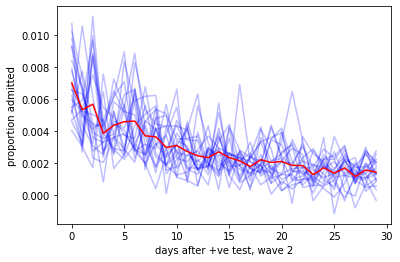

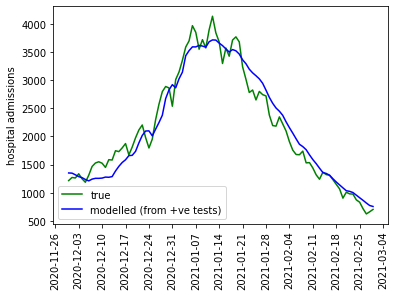

In [8]:
plt.clf()
x = list(range(len(pos)))
for y in cases_admiss_outputs:
    #print(sum(y))
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg_cases_admiss = []
for i in range(len(y)):
    y_avg_cases_admiss.append(np.mean(cases_admiss_outputs[:,i]))
plt.plot(x, y_avg_cases_admiss, color="red", alpha=1)
plt.xlabel("days after +ve test, wave %d" % wave)
plt.ylabel("proportion admitted")
plt.savefig("cases_admiss_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _f(y_avg_cases_admiss, cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled (from +ve tests)")
#plt.xlabel("days after start of wave %d" % wave)
plt.ylabel("hospital admissions")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()


cases_admiss[wave] = y_avg_cases_admiss

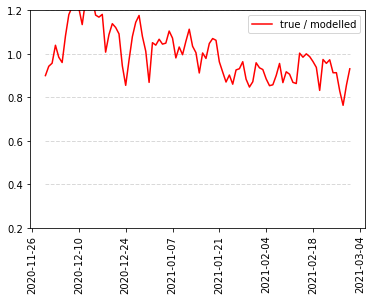

[0.8999992  0.94282784 0.95700131 1.03950319 0.98429969 0.96019593
 1.08284196 1.1803894  1.2165653  1.23450559 1.20930811 1.13457042
 1.24507918 1.22852289 1.26030196 1.17826837 1.16878987 1.18151044
 1.00785847 1.08875384 1.13873466 1.12136678 1.09197072 0.94478929
 0.85513475 0.97123499 1.07932999 1.1449814  1.17658014 1.08007863
 1.01207563 0.86874895 1.05139963 1.04005764 1.06716894 1.04476175
 1.04924178 1.10490721 1.07235697 0.98132602 1.03150438 0.99605619
 1.05772045 1.11325448 1.03488385 1.00565114 0.91205496 1.00409673
 0.97891445 1.04753308 1.07039507 1.06243476 0.96321717 0.91633767
 0.87039424 0.9025762  0.86042674 0.92610584 0.93162306 0.96385976
 0.88331926 0.84733786 0.8716692  0.9589204  0.93581684 0.92780959
 0.8848067  0.85357416 0.85772167 0.90038515 0.95580674 0.86770711
 0.91742743 0.90629238 0.86877927 0.86351693 1.00329301 0.98454746
 1.00003066 0.98740509 0.96459025 0.93774741 0.83190845 0.97399275
 0.95630721 0.97276222 0.91303429 0.91334315 0.82919179 0.7633

In [9]:
plt.clf()
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="true / modelled")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.ylim(0.2,1.2)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

print((true/pred))

2 0.08525468873105009 (10.50803716773192,)


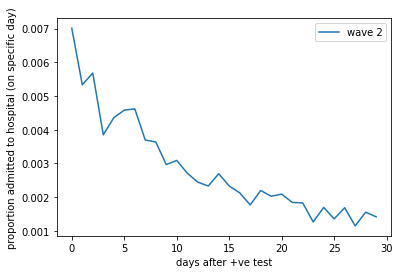

In [10]:
for wave,y_avg_cases_admiss in cases_admiss.items():
    print(wave, np.sum(y_avg_cases_admiss), center_of_mass(np.array(y_avg_cases_admiss)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg_cases_admiss in cases_admiss.items():
    if (wave==4):
        continue
    plt.plot(x, y_avg_cases_admiss, label="wave %d" % wave)
plt.xlabel("days after +ve test")
plt.ylabel("proportion admitted to hospital (on specific day)")
plt.legend()
plt.savefig("cases_admiss_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()
#print(list(zip(x,y_avg_cases_admiss)))

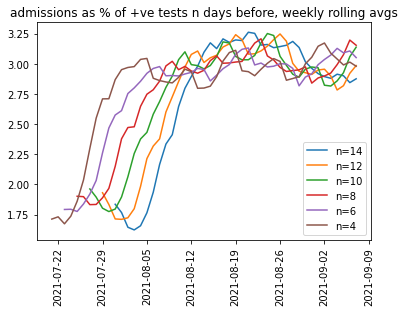

In [11]:
x_dateTimes = df.dateTime.to_list()[-len(x)-30:]

y = {}
admiss_rolling = {}
cases_rolling = {}
for n in [14,12,10,8,6,4]:
    _y1 = []
    _y2 = []
    _y = []
    for dateTime in x_dateTimes[n+7:]:
        dateTime1 = dateTime - datetime.timedelta(days=8)
        dateTime2 = dateTime 
        y1 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newAdmissions.to_list())
        _y1.append(y1/7)
        dateTime1 = dateTime1 - datetime.timedelta(days=n)
        dateTime2 = dateTime2 - datetime.timedelta(days=n)
        y2 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newCasesBySpecimenDate.to_list())
        _y2.append(y2/7)
        _y.append(y1/y2)
    y[n] = np.array(_y)
    admiss_rolling[n] = np.array(_y1)
    cases_rolling[n] = np.array(_y2)

plt.clf()
plt.title("admissions as % of +ve tests n days before, weekly rolling avgs")
for n,_y in y.items():
    plt.plot(x_dateTimes[n+7:], _y*100, label="n=%d" % n)
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
#plt.ylim(2,None)
plt.legend()
plt.savefig("test_vs_admiss_n_days_ago", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()



In [24]:
def cumsumflip(x):
    return np.flip(np.cumsum(np.flip(x)))

def _g(x, in_stream, out_stream):
    # model each 1 from in_stream as remaining present for a period with distribution x, in out_stream
    target_out_stream = out_stream[len(x)-1:]
    _x = cumsumflip(x)
    pred_out_stream = np.convolve(in_stream, _x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs, in_stream=admissions_stream, out_stream=occupancy_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
        ret[i] += 1e4*abs(1-np.sum(x)) if np.sum(x)>1 else 0
    return ret    

print(_g(np.array([0.5,0.6]), [1,1,1,3,3,3], [0,1,2,3,4,5]))

([1, 2, 3, 4, 5], array([1.7, 1.7, 3.9, 5.1, 5.1]))


In [51]:
n_dim = 30
n_particles = 1000

x_max = 0.25*np.ones(n_dim)
x_min = -0.05*np.ones(n_dim)
options = {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
bounds = (x_min, x_max)
#init_pos = np.array([x_min for i in range(n_particles)])
init_pos = None

admiss_occup_outputs = []

In [53]:
for i in range(10):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    admiss_occup_outputs.append(pos)
admiss_occup_outputs = np.array(admiss_occup_outputs)

2021-09-10 08:16:39,209 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=140  
2021-09-10 08:16:48,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 139.6609544508583, best pos: [ 0.1043074   0.05305864 -0.00411039  0.14646181  0.02881608  0.08560458
  0.00452464 -0.0275534   0.00577379  0.04408937  0.02634251  0.0015781
 -0.01670461  0.06728962  0.00539294 -0.01980975  0.03515068 -0.0096817
 -0.03698835 -0.02269439 -0.01309533  0.03247464 -0.00805836 -0.00276866
 -0.03685689  0.00759916  0.03129448  0.06891537  0.02881962  0.09854429]
2021-09-10 08:16:48,511 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=145  
2021-09-10 08:16:58,073 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 144.79667350615

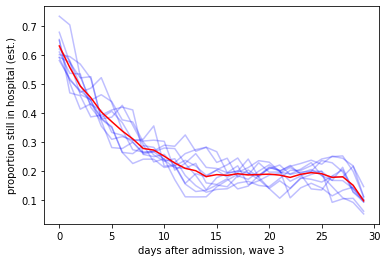

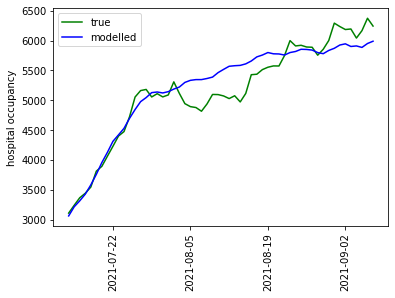

In [54]:
plt.clf()
x = list(range(len(pos)))
for y in admiss_occup_outputs:
    plt.plot(x, cumsumflip(y), color="blue", alpha=0.25)
y_avg_admiss_occup = []
for i in range(len(y)):
    y_avg_admiss_occup.append(np.mean(admiss_occup_outputs[:,i]))
plt.plot(x, cumsumflip(y_avg_admiss_occup), color="red", alpha=1)
plt.xlabel("days after admission, wave %d" % wave)
plt.ylabel("proportion still in hospital (est.)")
plt.savefig("admiss_occup_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _g(np.array(y_avg_admiss_occup), admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled")
plt.ylabel("hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

admiss_occup[wave] = y_avg_admiss_occup

In [1]:
plt.clf()
true, pred = _g(y_avg_admiss_occup, admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="[true / modelled] hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.6,None)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

NameError: name 'plt' is not defined

2 0.9788188213275564 (9.016518867783214,)
3 0.6303837471230059 (11.411254618395345,)


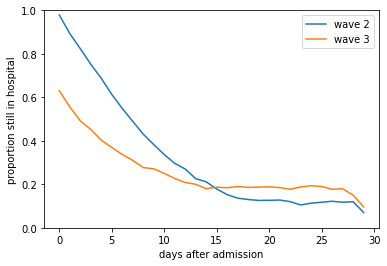

In [56]:
for wave,y_avg_admiss_occup in admiss_occup.items():
    print(wave, np.sum(y_avg_admiss_occup), center_of_mass(np.array(y_avg_admiss_occup)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg_admiss_occup in admiss_occup.items():
    if wave==4:
        continue
    plt.plot(x, cumsumflip(y_avg_admiss_occup), label="wave %d" % wave)
plt.xlabel("days after admission")
plt.ylabel("proportion still in hospital")
plt.legend()
plt.savefig("admiss_occup_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.ylim(0,1)
plt.show()
#print(list(zip(x,y_avg_admiss_occup)))

In [57]:
print(cumsumflip(y_avg_admiss_occup))

[0.63038375 0.5563235  0.49222496 0.45222776 0.40307487 0.36944806
 0.33724373 0.3100481  0.27688403 0.27142026 0.25031462 0.22687892
 0.20832974 0.20026684 0.17997222 0.18681425 0.18419819 0.18980143
 0.18582822 0.18707532 0.18841658 0.18506692 0.17721939 0.18791786
 0.19362596 0.18988383 0.1773586  0.17936534 0.14999304 0.0962469 ]
